# COVID-19

In [25]:
%matplotlib inline
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import re
import json
from pandas.io.json import json_normalize
import folium
from folium import plugins

import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = True)

from wordcloud import WordCloud

import plotly.express as px
from datetime import datetime,date,time
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import register_matplotlib_converters  
import os
import warnings
warnings.filterwarnings('ignore')

## 1.COVID-19 데이터에 대한 전반적 분석

* 이 부분은 앞부분에 다른 그래프랑 비교하는 용도로 쓰면 좋을것 같습니다. 그래프는 시각적으로 편안하지만, 변수가 많아질수록 범례도 늘어나고 오히려 해석하기 어려운 감이 있거든요. 반면에 히트맵은 생각보다 한눈에 비교하기 좋습니다.

In [26]:
import pandas as pd
import os
data_path = os.getenv('HOME')+'/workplace/coding_study/COVID-19'
print(data_path)
Case = pd.read_csv(data_path+"/Case.csv")
PatientInfo = pd.read_csv(data_path+"/PatientInfo.csv")
Time = pd.read_csv(data_path+"/Time.csv", parse_dates=['date'])
TimeAge = pd.read_csv(data_path+"/TimeAge.csv")
TimeProvince = pd.read_csv(data_path+"/TimeProvince.csv")

/home/aiffel-dj13/workplace/coding_study/COVID-19


In [27]:
Time.tail(10)
df_cases = Time.copy().drop(['date', 'time'], axis=1)
df_t = df_cases.tail(1)
df_t["Mortality Rate (%)"] = np.round(100*df_t["deceased"]/df_t["confirmed"],2)
df_t['test'] = df_t['test'].apply(lambda x:format(x,","))
df_t['negative'] = df_t['negative'].apply(lambda x:format(x,","))
df_t['released'] = df_t['released'].apply(lambda x:format(x,","))
df_t['confirmed'] = df_t['confirmed'].apply(lambda x:format(x,","))
df_t.reset_index(0)
df_t.style.background_gradient(cmap='summer',axis=1).set_properties(**{'font-size': '12pt'})

In [28]:
recentDate = TimeProvince['date'].max()
df_t = TimeProvince[TimeProvince['date']== recentDate]
df_t = df_t.copy().drop(['date', 'time'], axis=1)
df_t["Mortality Rate (%)"] = np.round(100*df_t["deceased"]/df_t["confirmed"],2)
#df_t['released'] = df_t['released'].apply(lambda x:format(x,","))
#df_t['confirmed'] = df_t['confirmed'].apply(lambda x:format(x,","))
df_t.reset_index(0)
df_t.style.background_gradient(cmap='summer',axis=1)\
      .background_gradient(cmap='YlOrBr',subset=["confirmed"])\
     .background_gradient(cmap='Reds',subset=["deceased"])\
     .background_gradient(cmap='Purples',subset=["Mortality Rate (%)"]).set_properties(**{'font-size': '10pt'})

In [30]:
for dirname, _, filenames in os.walk('aiffel-dj50/workplace/coding_study/COVID-19'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 2.검사수, 음성판정, 확진판정

In [31]:
time = pd.read_csv(data_path + "/Time.csv")
timeage = pd.read_csv(data_path + "/TimeAge.csv")
searchtrend = pd.read_csv(data_path + "/SearchTrend.csv")
patientinfo = pd.read_csv(data_path + "/PatientInfo.csv")

In [32]:
time

date  time     test  negative  confirmed  released  deceased
0    2020-01-20    16        1         0          1         0         0
1    2020-01-21    16        1         0          1         0         0
2    2020-01-22    16        4         3          1         0         0
3    2020-01-23    16       22        21          1         0         0
4    2020-01-24    16       27        25          2         0         0
..          ...   ...      ...       ...        ...       ...       ...
158  2020-06-26     0  1232315   1200885      12602     11172       282
159  2020-06-27     0  1243780   1211261      12653     11317       282
160  2020-06-28     0  1251695   1219975      12715     11364       282
161  2020-06-29     0  1259954   1228698      12757     11429       282
162  2020-06-30     0  1273766   1240157      12800     11537       282

[163 rows x 7 columns]

In [33]:
time.isnull().any()

date         False
time         False
test         False
negative     False
confirmed    False
released     False
deceased     False
dtype: bool

In [34]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163 entries, 0 to 162
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       163 non-null    object
 1   time       163 non-null    int64 
 2   test       163 non-null    int64 
 3   negative   163 non-null    int64 
 4   confirmed  163 non-null    int64 
 5   released   163 non-null    int64 
 6   deceased   163 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 9.0+ KB


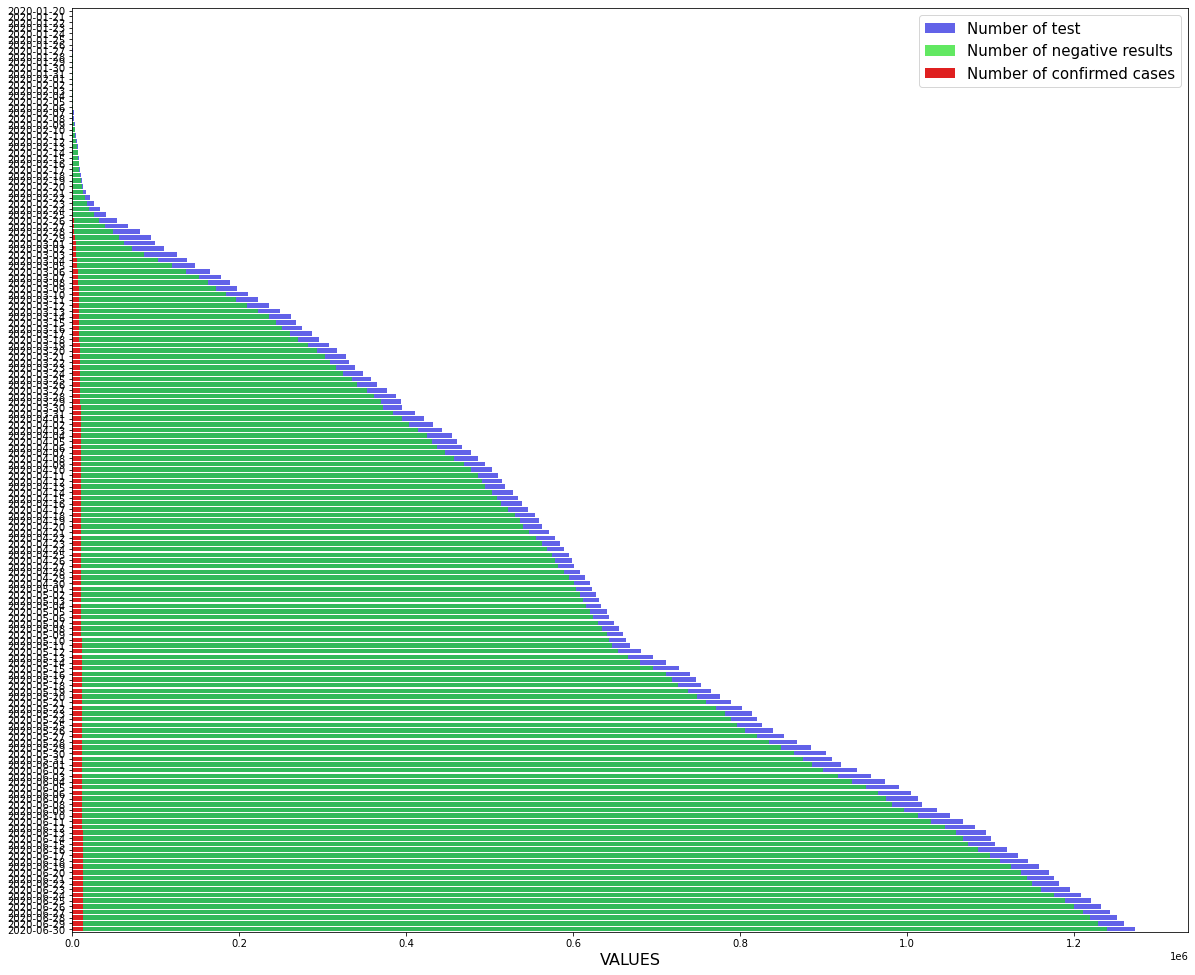

In [20]:
plt.subplots(figsize = (20,17))
date_list = [i for i in time.date]
sns.barplot(x=time.test, y=date_list,color ='b',label="Number of test",alpha=0.7)
sns.barplot(x=time.negative, y=date_list,color ='lime',label = "Number of negative results",alpha=0.7)
sns.barplot(x=time.confirmed, y=date_list,color='red',label = "Number of confirmed cases",alpha=1)
plt.xlabel("VALUES",fontsize = 16)
plt.legend(prop={'size': 15})
plt.show()

## 3.시도별/연령별 평균 회복 기간

In [35]:
PatientInfo['confirmed_date'] = PatientInfo['confirmed_date'].apply(pd.to_datetime)
PatientInfo['released_date'] = PatientInfo['released_date'].apply(pd.to_datetime)
released_people = PatientInfo[PatientInfo['released_date'].isnull() == 0]
released_people['recover_period'] = released_people['released_date'] - released_people['confirmed_date']

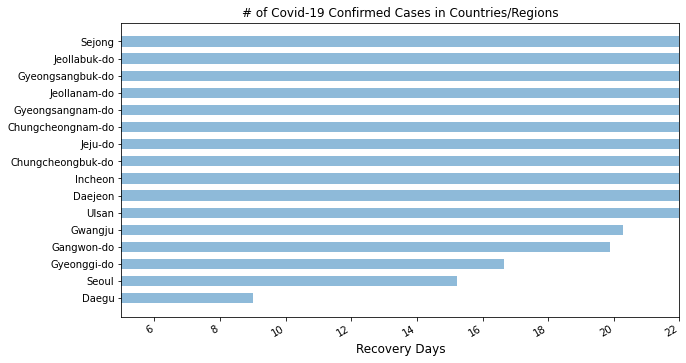

In [22]:
temp2 = released_people.groupby('province')['recover_period'].sum().reset_index()
temp3 = released_people.groupby('province')['recover_period'].count().reset_index()
aa = pd.merge(temp2, temp3, on='province')

aa['recover_mean'] = aa['recover_period_x'].dt.days / aa['recover_period_y']
aa.sort_values(by='recover_mean', ascending=True, inplace=True)
fig, ax = plt.subplots(1,1,figsize=(10,6))
plt.barh(aa['province'], aa['recover_mean'] ,height=0.6,alpha=0.5)
plt.title('# of Covid-19 Confirmed Cases in Countries/Regions', size=12)
plt.xlabel('Recovery Days', size=12)
ax.set_xlim([5,22])
fig.autofmt_xdate()

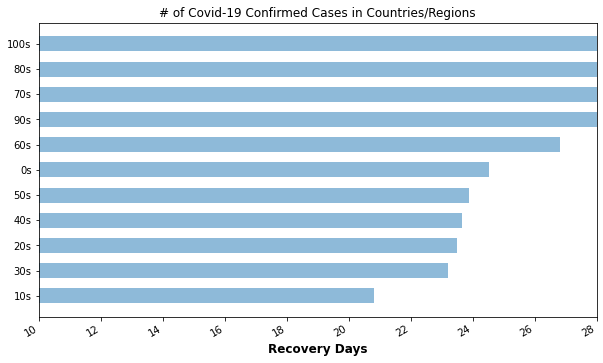

In [36]:
released_people.head()
temp2 = released_people.groupby('age')['recover_period'].sum().reset_index()
temp3 = released_people.groupby('age')['recover_period'].count().reset_index()
aa = pd.merge(temp2, temp3, on='age')
aa['recover_mean'] = aa['recover_period_x'].dt.days / aa['recover_period_y']

fig, ax = plt.subplots(1,1,figsize=(10,6))
aa.sort_values(by='recover_mean', ascending=True, inplace=True)
plt.barh(aa['age'], aa['recover_mean'] ,height=0.6,alpha=0.5)
plt.title('# of Covid-19 Confirmed Cases in Countries/Regions', size=12)
plt.xlabel('Recovery Days', fontsize=12,fontweight="bold")
ax.set_xlim([10,28])
fig.autofmt_xdate()

## 4.환자 정보 wordcloud

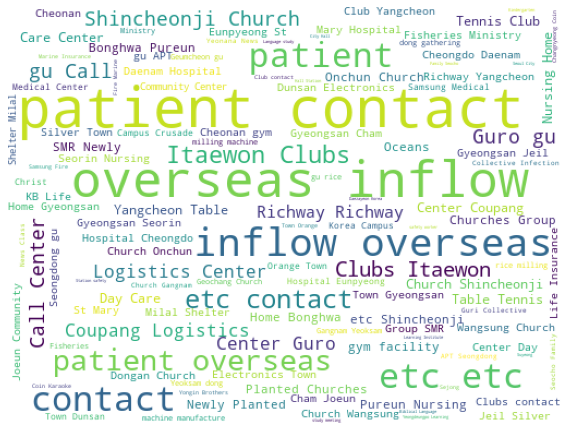

In [37]:
patientinfo2 = patientinfo.dropna(subset=["infection_case"])
patientinfo2[patientinfo2.infection_case.isnull()]

plt.subplots(figsize=(10,10))

wordcloud = WordCloud(background_color='white', width=512, height=384).generate(" ".join(patientinfo2.infection_case))

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## 5.검색 추이

In [38]:
#Create Figures
fig = go.Figure()

#Add Traces
fig.add_trace(go.Scatter(x=searchtrend.date, y=searchtrend.cold, mode='markers',text=searchtrend.cold, name="Cold"))
fig.add_trace(go.Scatter(x=searchtrend.date, y=searchtrend.flu, mode='markers',text=searchtrend.flu, name="Flue"))
fig.add_trace(go.Scatter(x=searchtrend.date, y=searchtrend.pneumonia, mode='markers',text=searchtrend.pneumonia, name="Pneumonia"))
fig.add_trace(go.Scatter(x=searchtrend.date, y=searchtrend.coronavirus, mode='markers', text=searchtrend.coronavirus, name="Coronovirus"))

#Update Layout
fig.update_layout(title='Search Trends',font_size=13,font_color='black', yaxis_type="log")

#Update Traces
fig.update_traces(marker_size = 3.5,opacity=0.8)

fig.show()

## 6.연령별 사망률

In [39]:
timeage.age = [i.rsplit('s',1)[0] if 's' in i else i for i in timeage.age]
timeage.age.value_counts()

60    121
10    121
40    121
0     121
80    121
50    121
70    121
30    121
20    121
Name: age, dtype: int64

In [40]:
death_by_age = timeage.groupby('age')['deceased'].sum()
death_by_age

age
0         0
10        0
20        0
30      194
40      295
50     1537
60     3743
70     7599
80    12136
Name: deceased, dtype: int64

In [41]:
#Create labels
labels = [str(each) +'s Years Old' for each in death_by_age.index]

#Create Figure
fig = go.Figure()

#Add traces
fig.add_trace(go.Pie(values= death_by_age, labels = labels, name="Deaths by Age",hoverinfo='label+percent+name'))

#Customize layout
fig.update_layout(title='Death Ratio by Age',font_size=15)

fig.show()

In [ ]:
'''
내 파트
'''

## 7.월별로 각 지역마다 발생한 환자의 수

In [ ]:
file_path = os.path.join(os.getenv('HOME'),'workplace/coding_study/COVID-19/PatientInfo.csv')

data = pd.read_csv(file_path, encoding = 'cp949')
data

In [ ]:
data = data.drop(['patient_id', 'contact_number', 'symptom_onset_date', 'released_date', 'deceased_date', 'state'], axis = 1)

In [ ]:
data['sex'].isnull().sum()

In [ ]:
data['age'].isnull().sum()

In [ ]:
data['country'].isnull().sum()

In [ ]:
data['province'].isnull().sum()

In [ ]:
data['confirmed_date'].isnull().sum()

In [ ]:
data.head(30)

In [ ]:
data.tail(30)

In [ ]:
data['confirmed_date'].isnull().sum()

In [ ]:
data = data.dropna(how='any',subset=['confirmed_date'])

In [ ]:
data

In [ ]:
data['confirmed_date'].dtypes

In [ ]:
data['confirmed_date'].apply(str)

In [ ]:
data['confirmed_date'] = data['confirmed_date'].str.slice(0,7)
data

In [ ]:
occr = data.loc[:,['province', 'confirmed_date']]
occr = occr[occr.confirmed_date != '2020-01']
occr['occurence'] = 1

occr = occr.groupby(['province', 'confirmed_date'], as_index=False).sum()
occr

In [ ]:
plt.rc('font',family='NanumBarunGothic')
plt.figure(figsize=(14,14))
sns.pointplot(data=occr, x='confirmed_date', y='occurence', hue='province')

In [ ]:
file_path = os.path.join(os.getenv('HOME'),'workplace/coding_study/COVID-19/Region.csv')
region_data = pd.read_csv(file_path, encoding = 'cp949')
region_data = region_data.drop(['city', 'elementary_school_count', 'kindergarten_count', 'university_count', 'academy_ratio', 'elderly_population_ratio', 'elderly_alone_ratio', 'nursing_home_count'], axis = 1)
region_data = region_data.groupby(['province'], as_index=False).min()
region_data

In [ ]:
def getMonth():
    month = ''
    while True:
        value = input('년월만 입력해주세요(202002~202006) : ')
        value = re.sub(r"[^a-zA-Z0-9]","",value)
        if value.isdecimal:
            if len(value) == 6:
                if int(value) < 202007 and int(value) > 202001:
                    month = value
                    break
                else:
                    continue
            else:
                continue
        else:
            continue
    month = month[:4]+"-"+month[4:]
    temp = occr[occr.confirmed_date == month]
    temp = temp.drop(['confirmed_date'], axis = 1)
    return temp


In [ ]:
def drawMap():

    state_data = getMonth()
    state_data['occurence'] = state_data['occurence'].astype(str)

    target_df = pd.merge(state_data,region_data, how = 'left', on = 'province')

    m = folium.Map(location=[36, 127], tiles="OpenStreetMap", zoom_start=7)

    for i in range(0,len(target_df)):
        latitude = target_df.iloc[i]['latitude']
        longitude = target_df.iloc[i]['longitude']
        location=(latitude, longitude)
        folium.CircleMarker(location, radius=pd.to_numeric(target_df.iloc[i]['occurence'])/15,color='#cc4331',fill_color='#cc4331', popup=target_df.iloc[i]['province']).add_to(m)
        
    folium.LayerControl(collapsed=False).add_to(m)

    return m

In [ ]:
drawMap()

## 8.확진자 수와 사망자 수가 가장 높은 10개 지방 <a id="2"></a>

* 이 부분은 확인자 데이터 6월 30일 기준 숫자입니다. 확진자, 사망자, 기타 정보가 포함되어 있습니다.

In [ ]:
recentDate = TimeProvince['date'].max()# 가장 최근날짜 변수 저장
df_t = TimeProvince[TimeProvince['date']== recentDate]# 가장 늦은 날짜의 데이터프레임 저장
f = plt.figure(figsize=(10,5))
f.add_subplot(1,1,1)# 위치 지정
df_t.set_index("province", inplace=True)# 인덱스 지정
plt.axes(axisbelow=True)
# barh: 수평그래프(인덱스, 수치)
plt.barh(df_t.sort_values('confirmed')["confirmed"].index[-10:],df_t.sort_values('confirmed')["confirmed"].values[-10:],color="skyblue")
plt.tick_params(size=5,labelsize = 13)# 눈금옵션
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 province (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)

## 한국내 확진자 수 - PatientInfo.csv

In [ ]:
info = pd.read_csv('PatientInfo.csv')

allpat = info.groupby('province').size()
allpat_df = pd.DataFrame(allpat).sort_values(by=[0], axis=0, ascending=False) # 내림차순 정렬
allpat_df = allpat_df.rename(columns = {0: 'size'})

plt.figure(figsize = (10, 5))
plt.bar(allpat_df.index, allpat_df['size'])
plt.xticks(rotation = 90)
plt.show()

In [ ]:
recentDate = TimeProvince['date'].max()
df_t = TimeProvince[TimeProvince['date']== recentDate]
f = plt.figure(figsize=(10,5))
f.add_subplot(111)
df_t.set_index("province", inplace=True)
plt.axes(axisbelow=True)
plt.barh(df_t.sort_values('deceased')["deceased"].index[-10:],df_t.sort_values('deceased')["deceased"].values[-10:],color="red")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("deceased Cases",fontsize=18)
plt.title("Top 10 province (deceased Cases)",fontsize=20)
plt.grid(alpha=0.3)

In [ ]:
recentDate = TimeProvince['date'].max()
df_t = TimeProvince[TimeProvince['date']== recentDate]
f = plt.figure(figsize=(10,5))
f.add_subplot(111)
df_t['active'] = df_t['confirmed'] - df_t['released'] - df_t['deceased']
df_t.set_index("province", inplace=True)
plt.axes(axisbelow=True)
plt.barh(df_t.sort_values('active')["active"].index[-10:],df_t.sort_values('active')["active"].values[-10:],color="pink")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("active Cases",fontsize=18)
plt.title("Top 10 province (active Cases)",fontsize=20)
plt.grid(alpha=0.3)

In [ ]:
recentDate = TimeProvince['date'].max()
df_t = TimeProvince[TimeProvince['date']== recentDate]
f = plt.figure(figsize=(10,5))
f.add_subplot(111)
df_t.set_index("province", inplace=True)
plt.axes(axisbelow=True)
plt.barh(df_t.sort_values('released')["released"].index[-10:],df_t.sort_values('released')["released"].values[-10:],color="yellow")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("released Cases",fontsize=18)
plt.title("Top 10 province (released Cases)",fontsize=20)
plt.grid(alpha=0.5)

## 9.각 시도의 전체 확진자 연령대별 비교
* 각 시도별로 같은 나이대의 확진자를 합산하여 비교

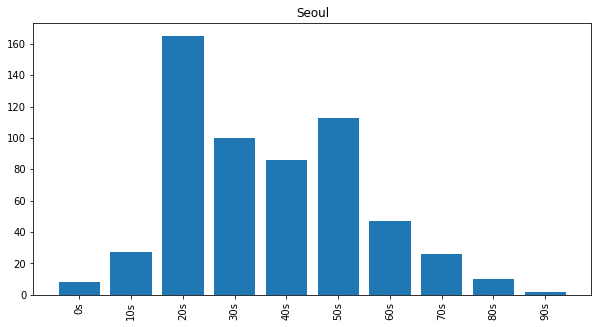

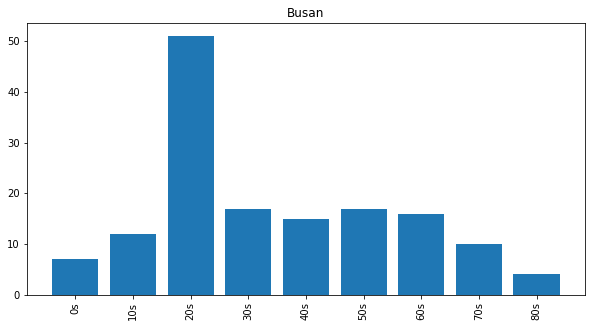

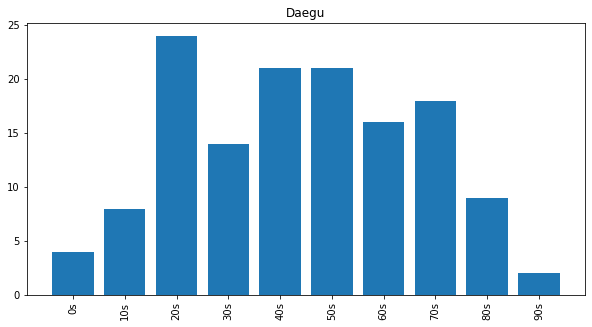

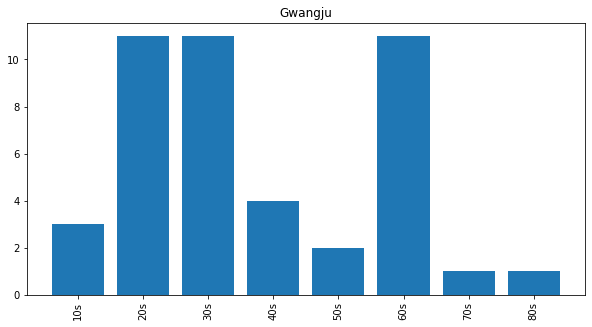

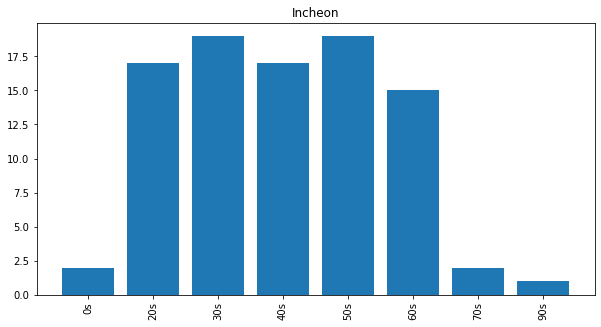

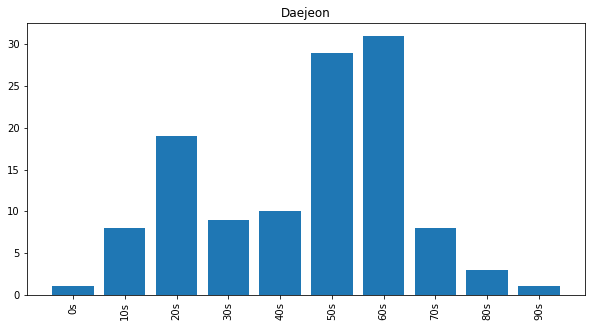

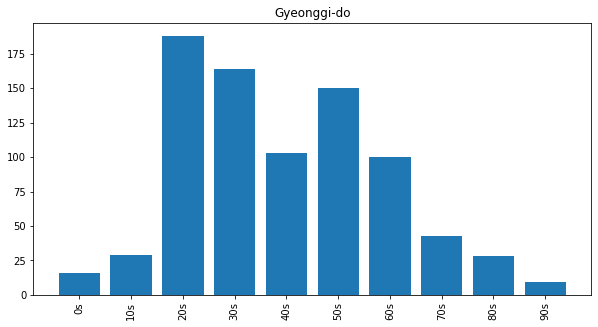

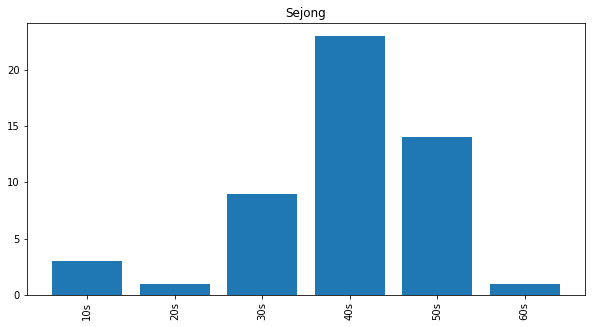

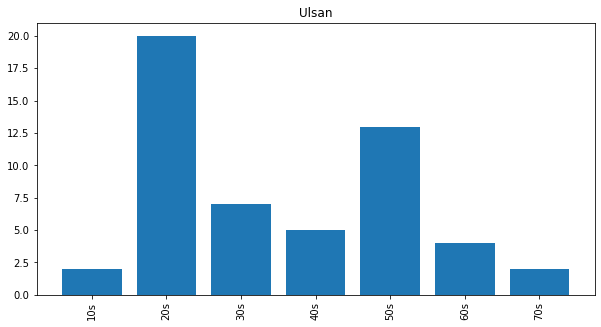

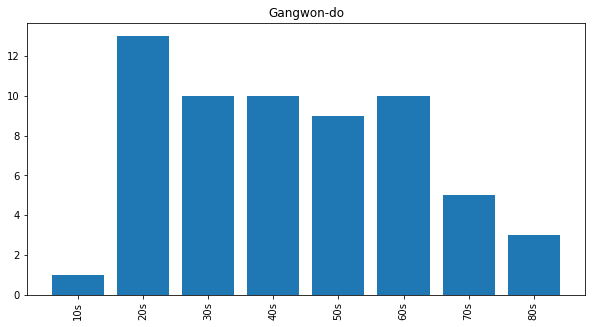

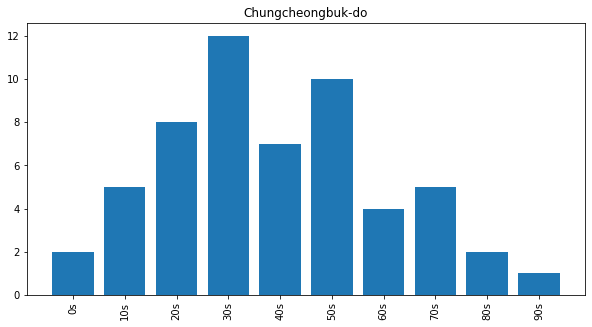

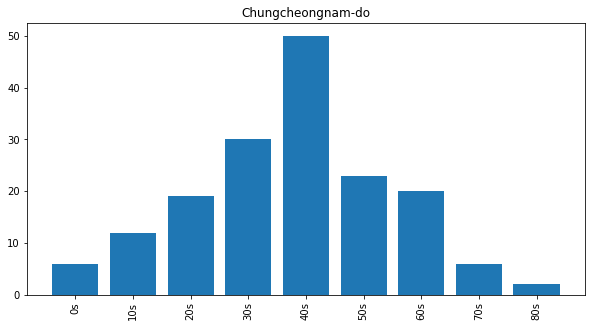

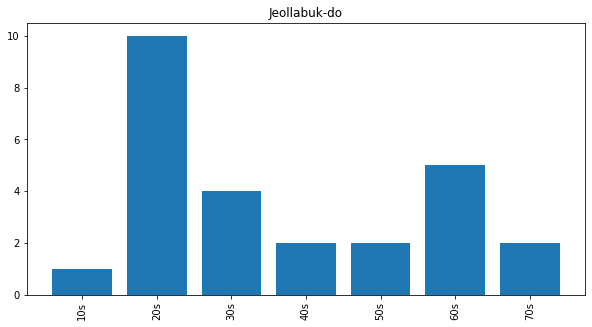

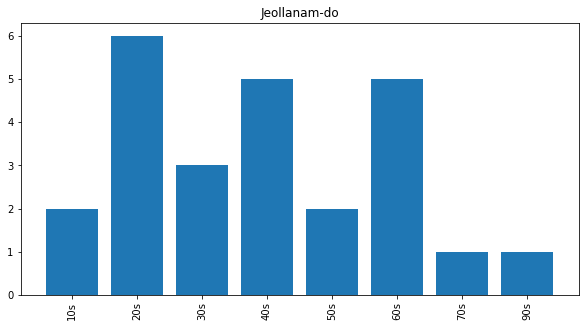

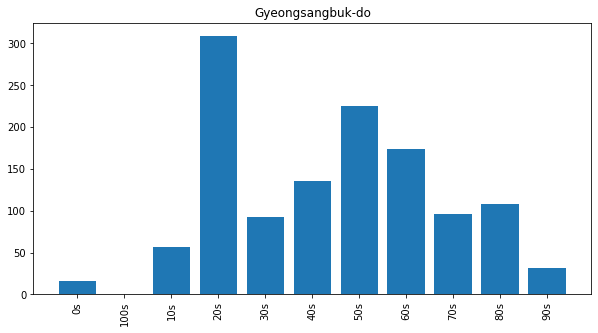

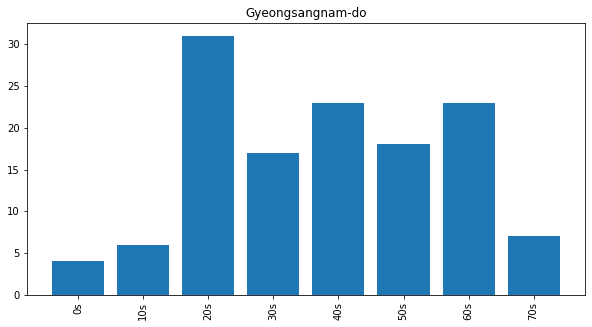

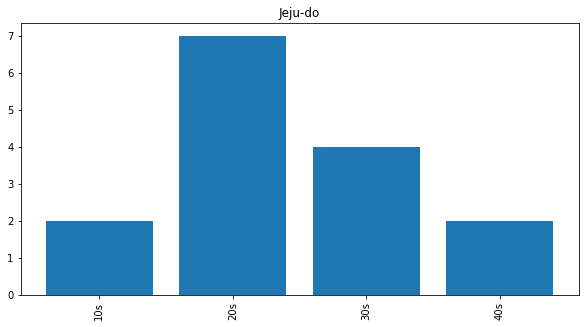

In [43]:
info = pd.read_csv('PatientInfo.csv')

province = info['province'].unique()  # 유일값 찾기

for name in province:
    age = info[info['province'] == name].groupby('age').size()
    age_df = pd.DataFrame(age)#.sort_values(by=[0], axis=0, ascending=False) # 이건 나이순으로 보는 게 좋아서 사이즈로 정렬 안 함
    age_df = age_df.rename(columns = {0: 'size'})
    plt.figure(figsize = (10, 5))
    plt.bar(age_df.index, age_df['size'])
    plt.xticks(rotation = 90)
    plt.title(name)
    plt.show()

## 10.Top 12 infection Case <a id="5"></a>

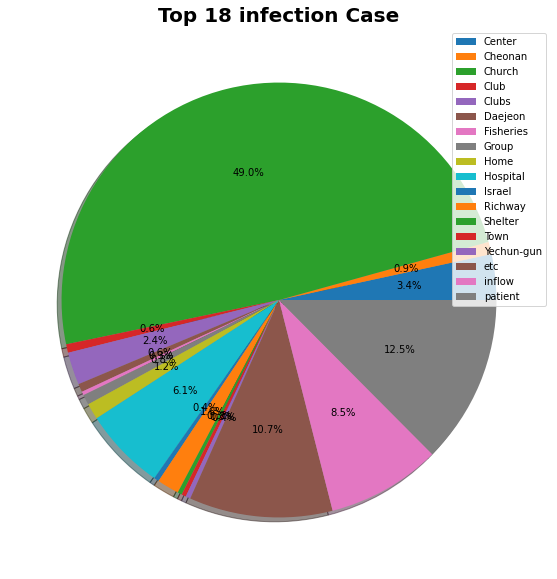

In [45]:
temp = Case['infection_case'].str.split()
for i in range(len(temp)):
    Case['infection_case'][i] = temp[i][-1]

cg = Case.groupby('infection_case').agg(sum)['confirmed']
data_pie = []
data_pie_index = []
for a in range(len(cg)):
    if cg[a] > 20:
        data_pie.append(cg[a])
        data_pie_index.append(cg.index[a])
number_case = len(data_pie)
explode=np.zeros(number_case)

fig = plt.gcf() 
fig.set_size_inches(10,10)
plt.pie(data_pie,autopct='%1.1f%%',shadow=True)
title = "Top "+str(number_case) +" infection Case" 
plt.title(title,fontsize=20, fontweight="bold")
plt.legend(data_pie_index, loc="best") # bbx required to place legend without overlapping
plt.show()

## 11.각 시도의 전체 확진자 성별 비율 비교
* 각 시도별로 확진자의 성별 비율

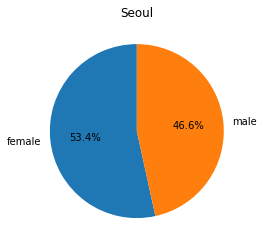

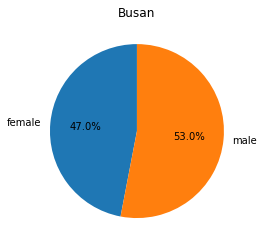

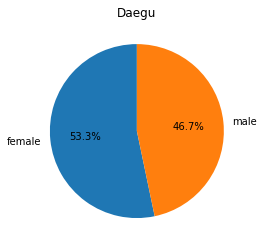

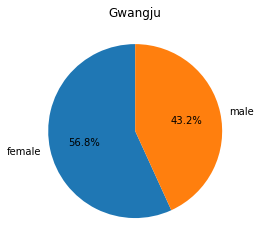

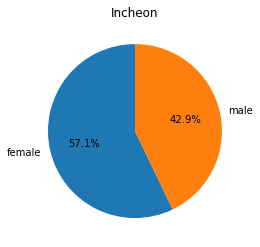

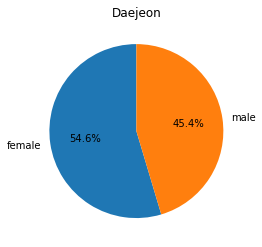

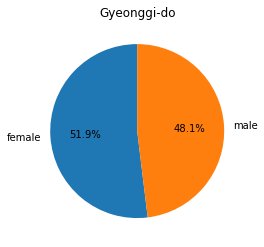

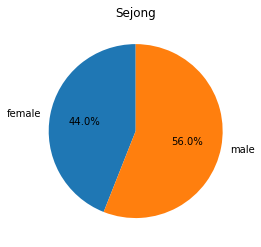

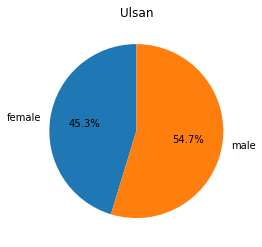

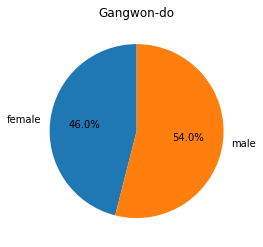

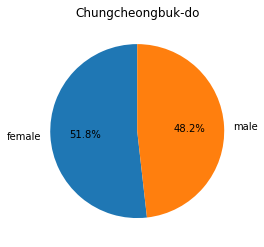

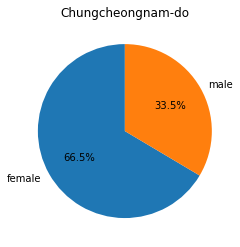

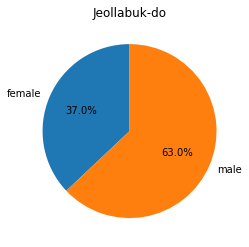

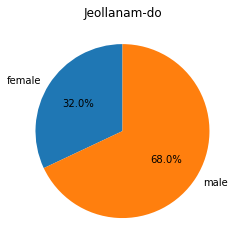

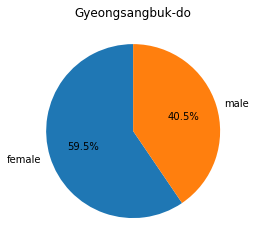

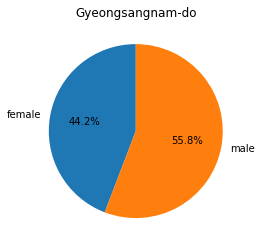

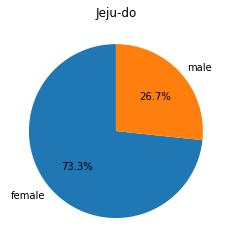

In [44]:
province = info['province'].unique()

for name in province:
    gender = info[info['province'] == name].groupby('sex').size()
    gender_df = pd.DataFrame(gender)
    gender_df = gender_df.rename(columns = {0: 'size'})
    
    all_gender = gender.sum()
    gender_ratio = gender_df['size']/all_gender
    labels = ['female', 'male']
    
    plt.figure()
    plt.pie(gender_ratio, labels = labels, autopct = '%.1f%%', startangle = 90)
    #plt.xticks(rotation = 90)
    plt.title(name)
    plt.show()

## 12.각 시도의 성별에 따른 연령별 확진자 수 비교   
* 한 성별만 남기고 제거 후 시도별로 나이를 그룹화하여 각 나이대별 사이즈 측정

### 12-1.여성 확진자의 연령대 비교

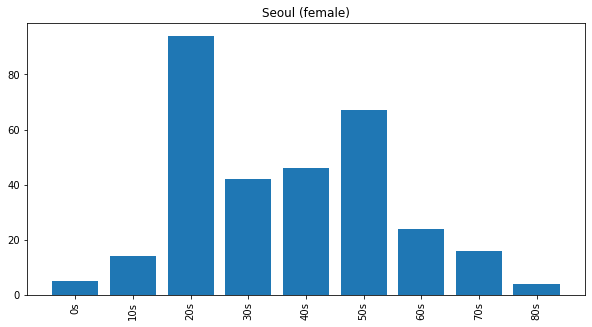

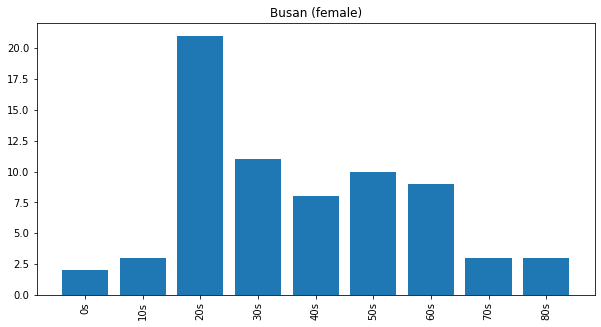

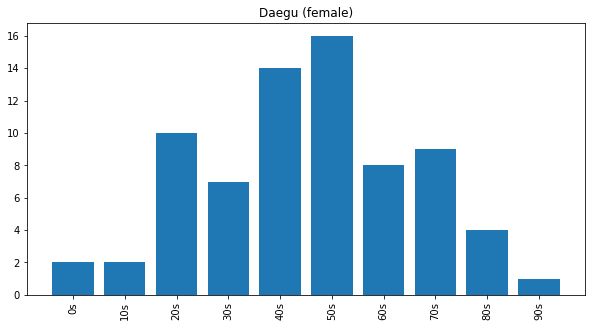

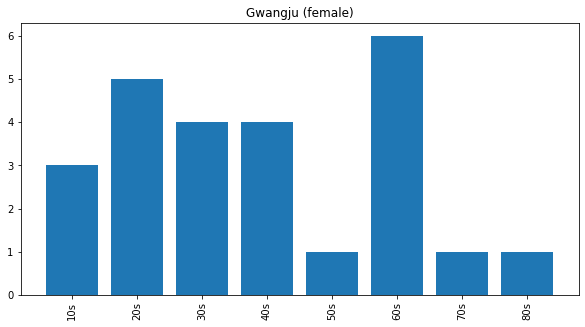

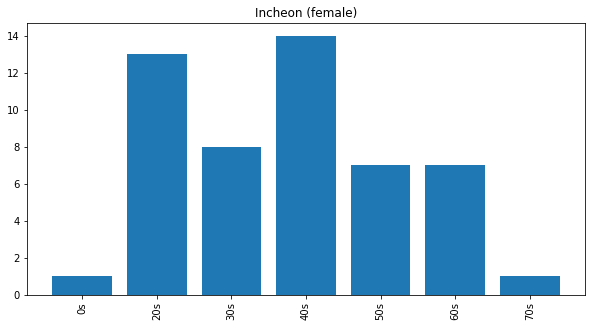

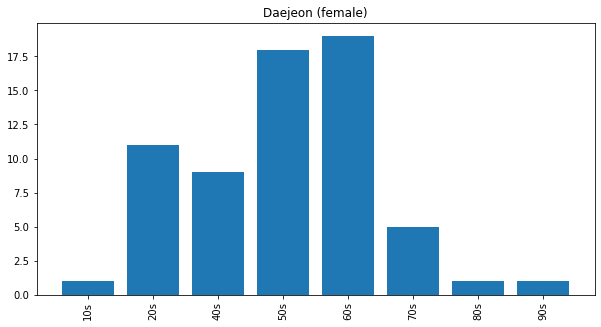

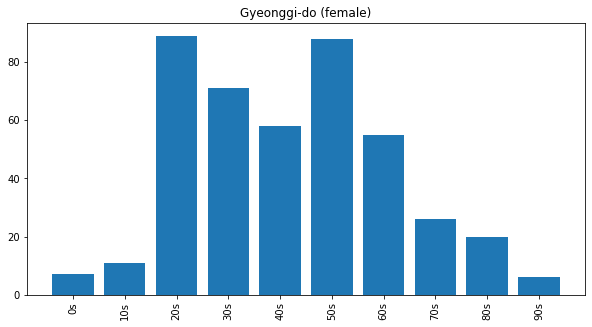

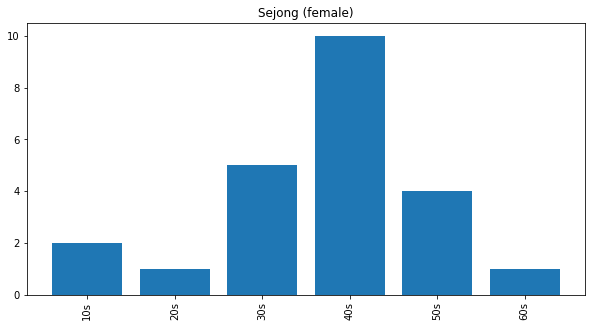

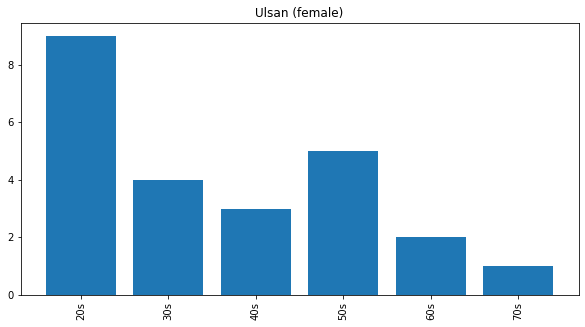

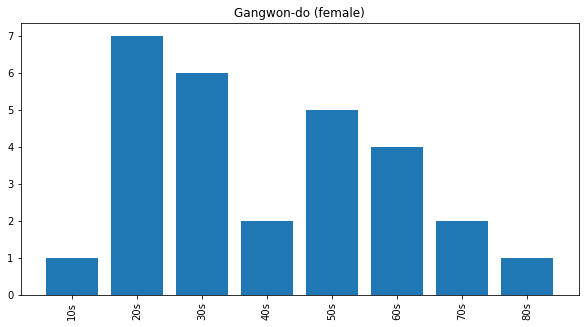

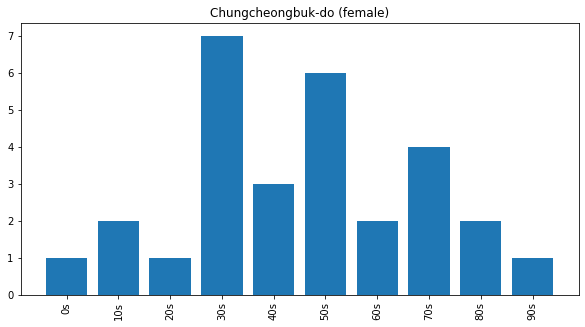

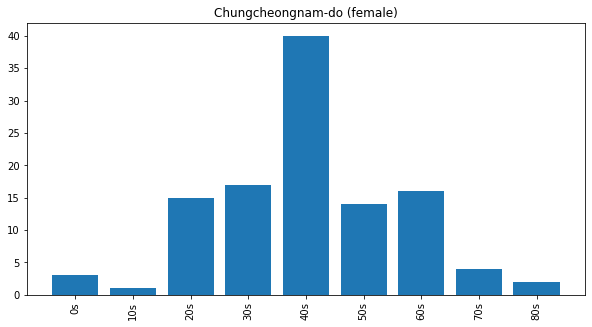

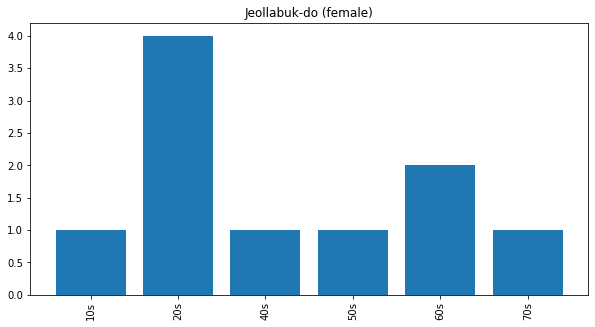

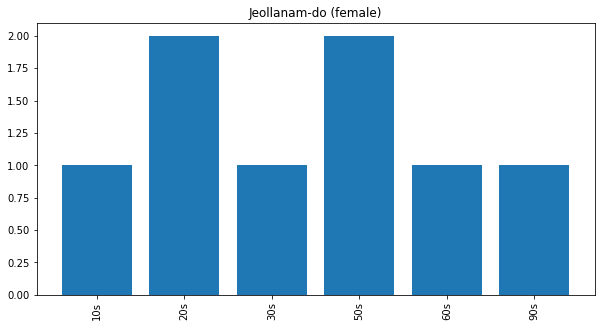

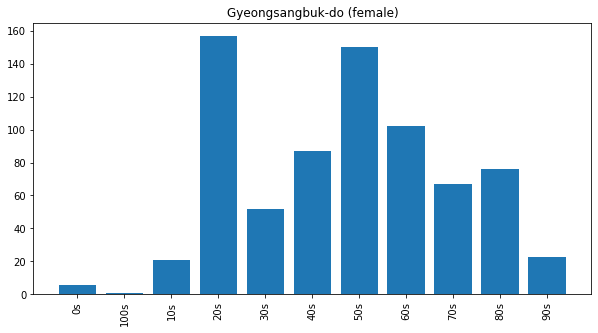

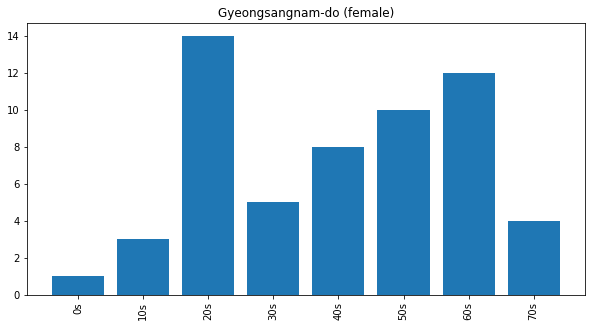

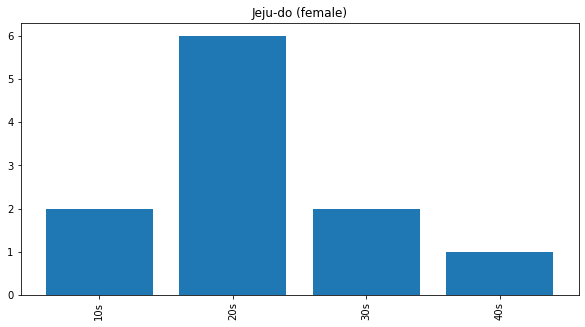

In [48]:
f_info = info.drop(info.loc[info['sex']=='male'].index, inplace=False)
f_info

province = f_info['province'].unique()

for name in province:
    age = f_info[f_info['province'] == name].groupby('age').size()
    age_df = pd.DataFrame(age)#.sort_values(by=[0], axis=0, ascending=False) # 이건 나이순으로 보는 게 좋아서 사이즈로 정렬 안 함
    age_df = age_df.rename(columns = {0: 'size'})
    plt.figure(figsize = (10, 5))
    plt.bar(age_df.index, age_df['size'])
    plt.xticks(rotation = 90)
    plt.title(name+' (female)')
    plt.show()

### 12-2.남성 확진자의 연령대 비교

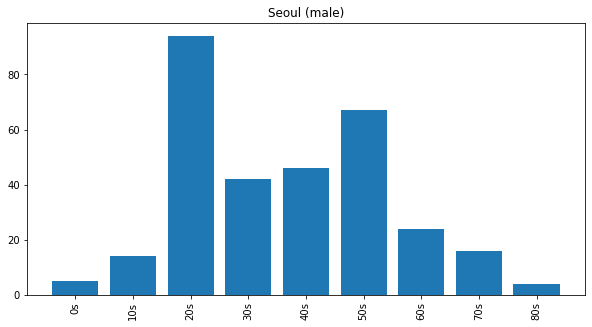

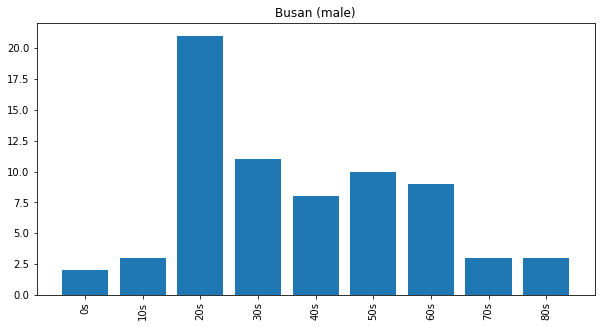

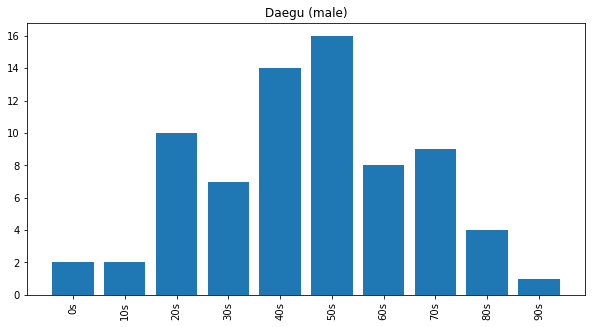

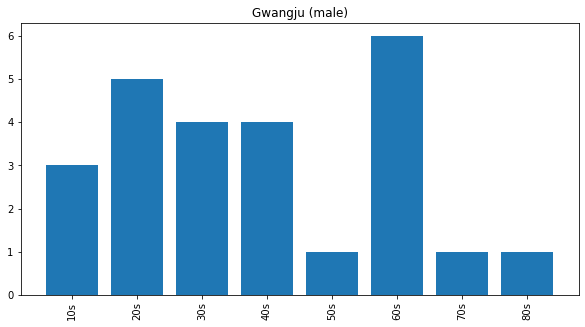

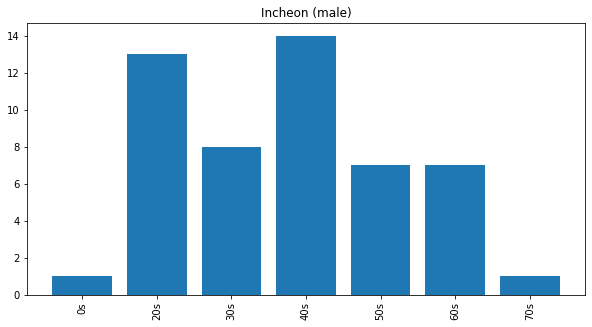

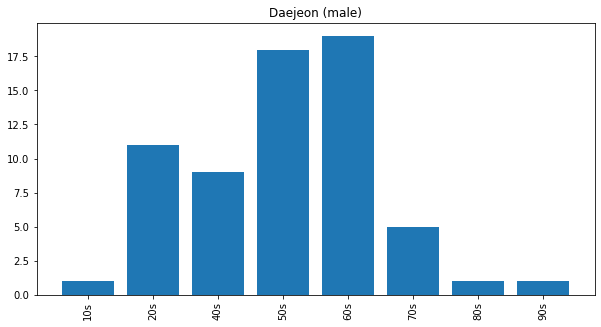

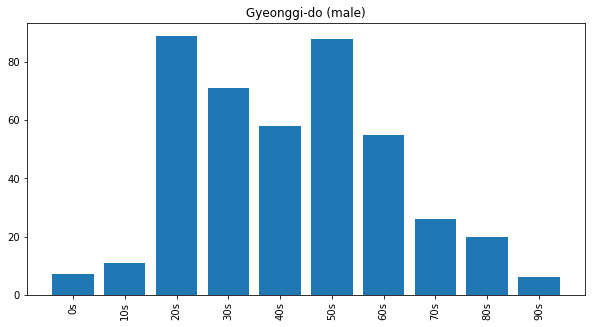

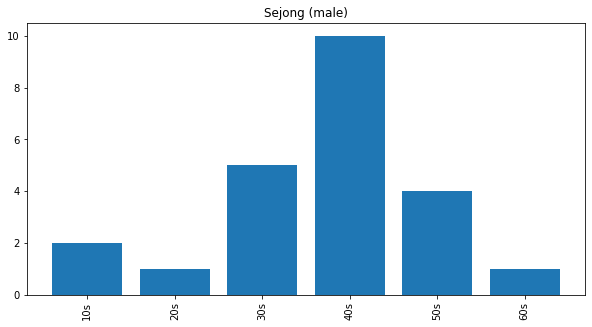

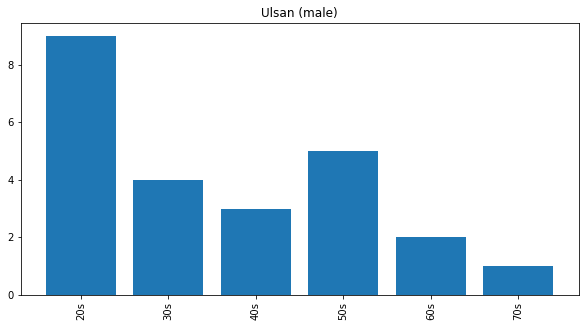

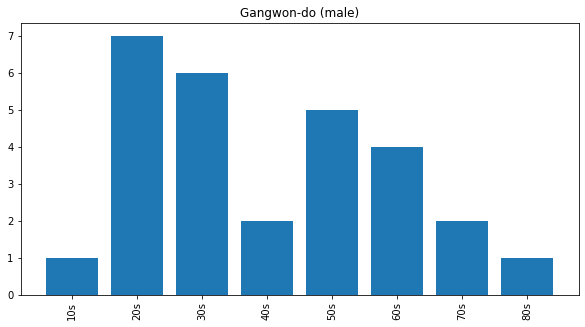

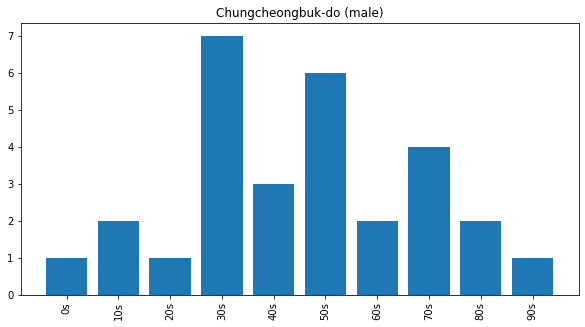

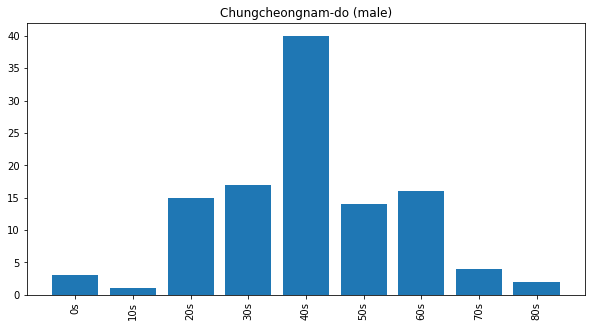

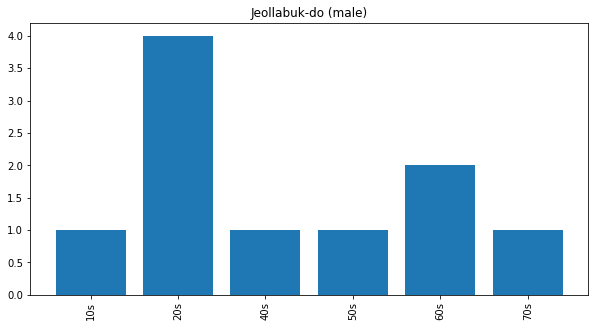

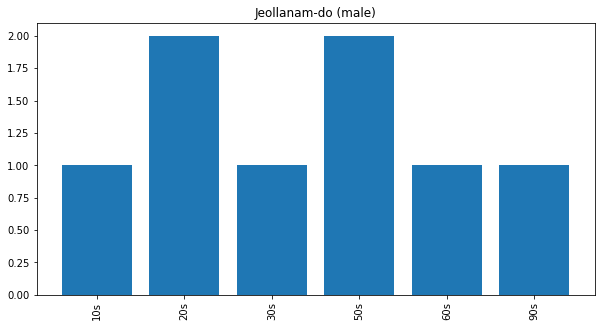

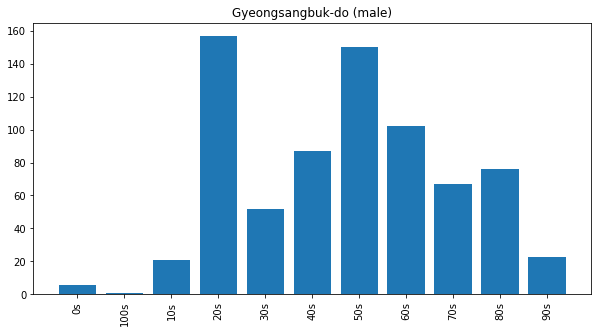

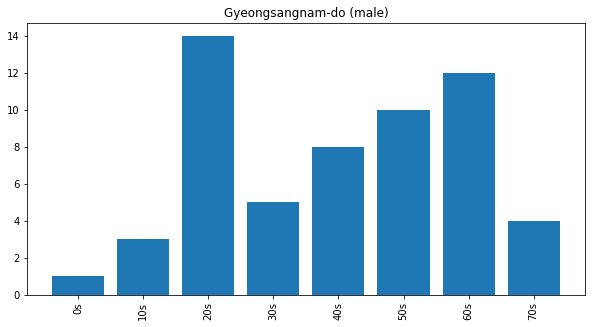

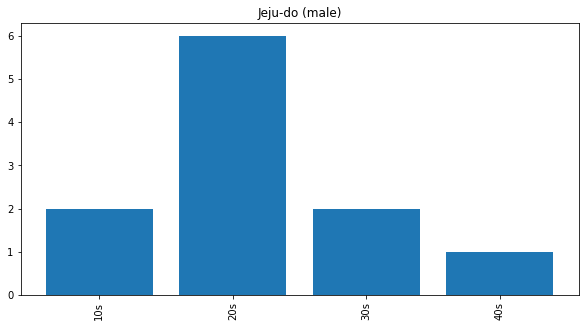

In [49]:
m_info = info.drop(info.loc[info['sex']=='female'].index, inplace=False)
m_info

province = f_info['province'].unique()

for name in province:
    age = f_info[f_info['province'] == name].groupby('age').size()
    age_df = pd.DataFrame(age)#.sort_values(by=[0], axis=0, ascending=False) # 이건 나이순으로 보는 게 좋아서 사이즈로 정렬 안 함
    age_df = age_df.rename(columns = {0: 'size'})
    plt.figure(figsize = (10, 5))
    plt.bar(age_df.index, age_df['size'])
    plt.xticks(rotation = 90)
    plt.title(name+' (male)')
    plt.show()

## 13.각 시도의 지역구별 확진자 수 - Case.csv

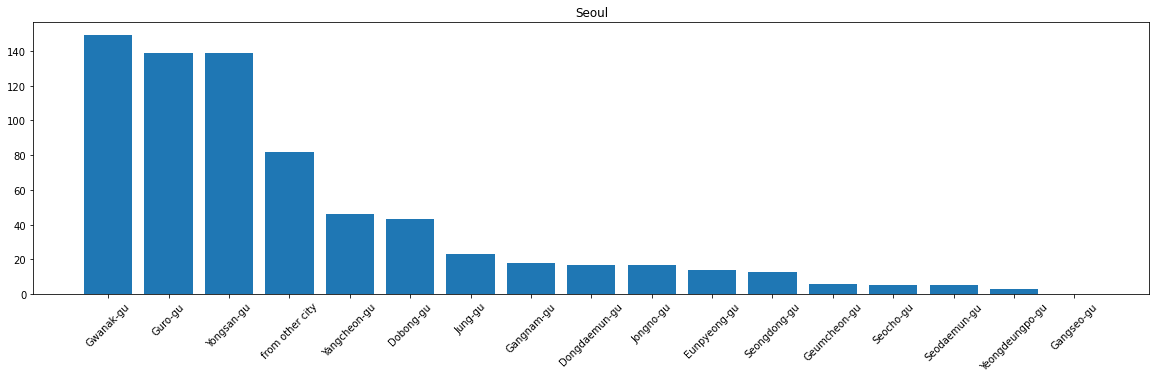

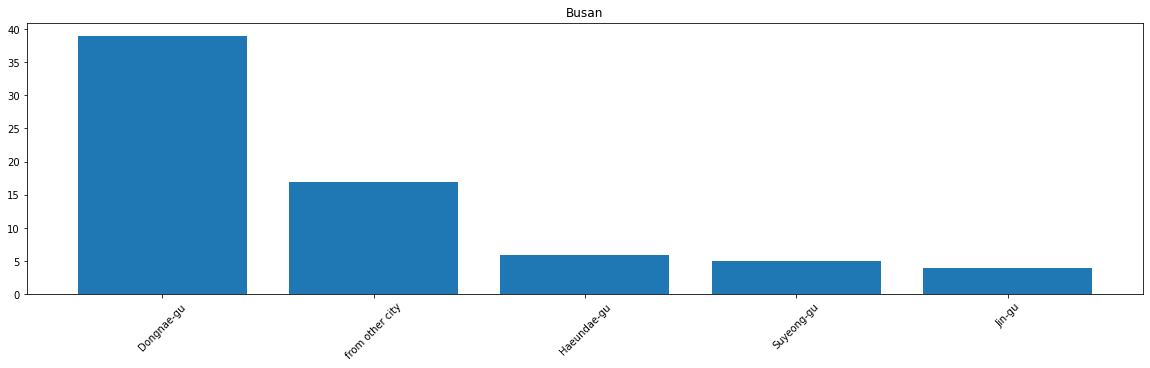

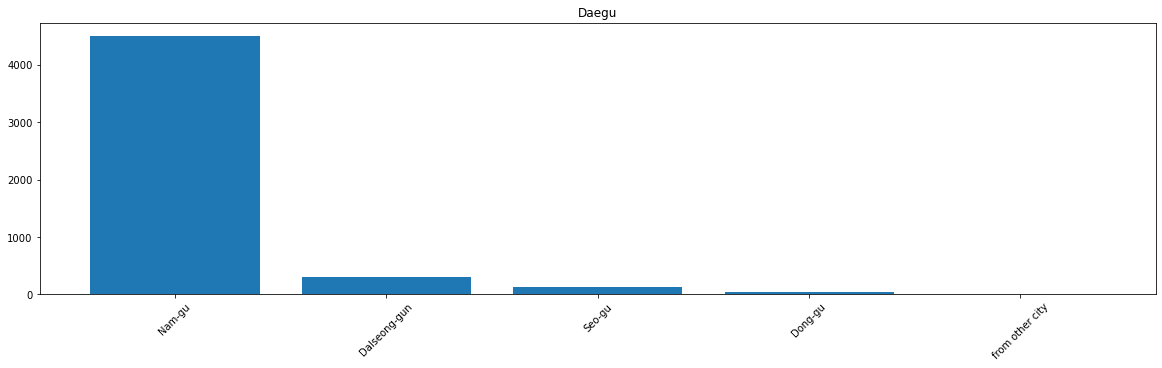

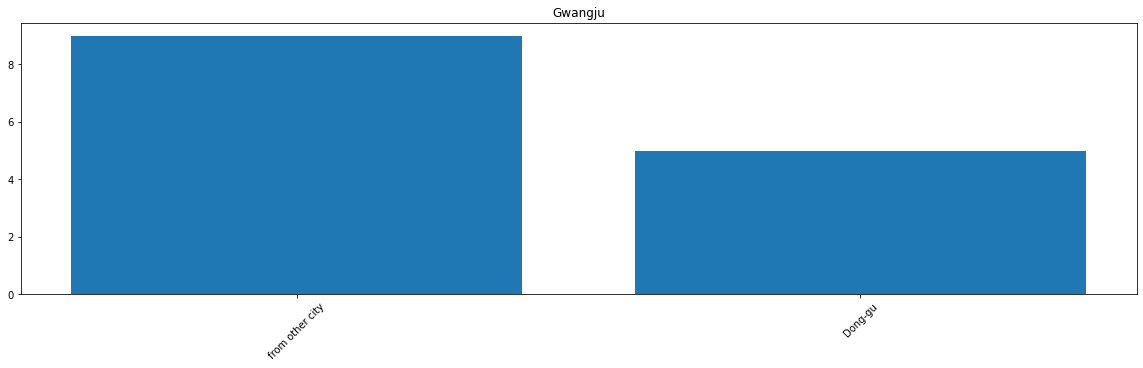

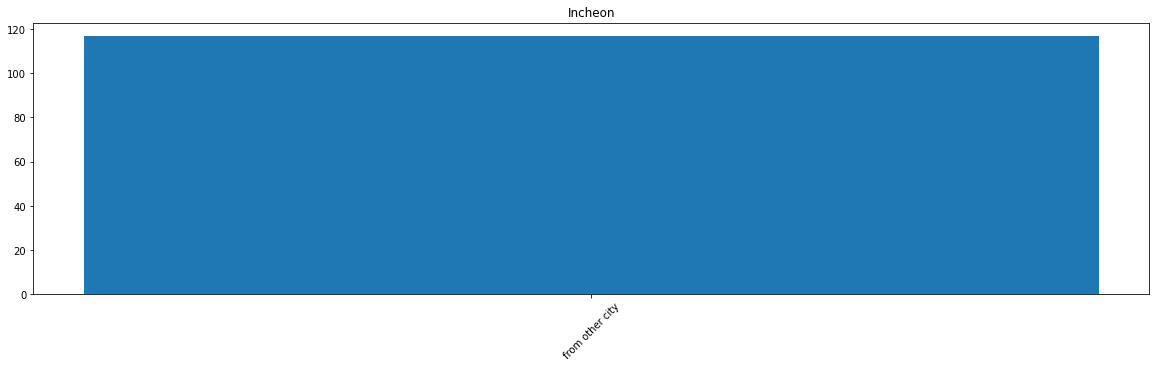

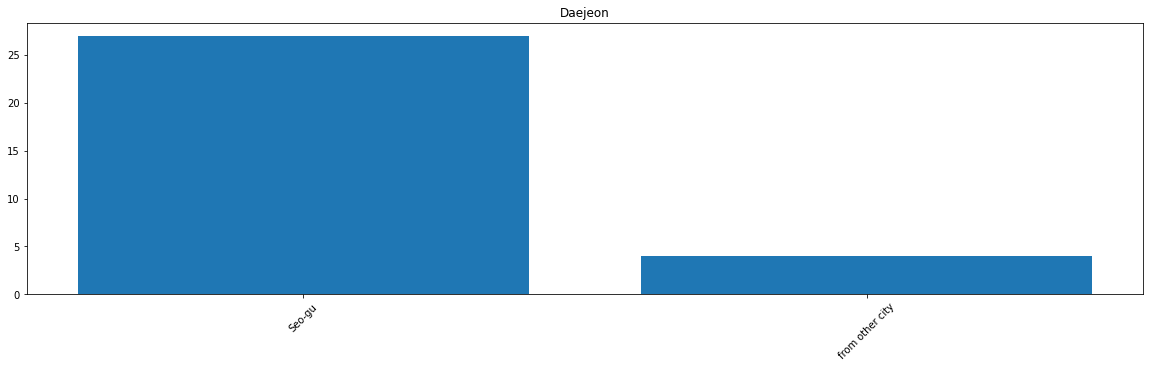

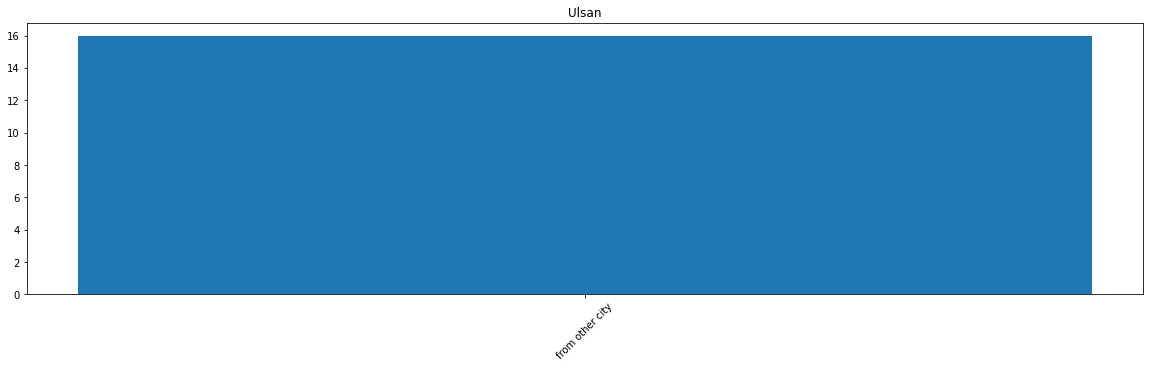

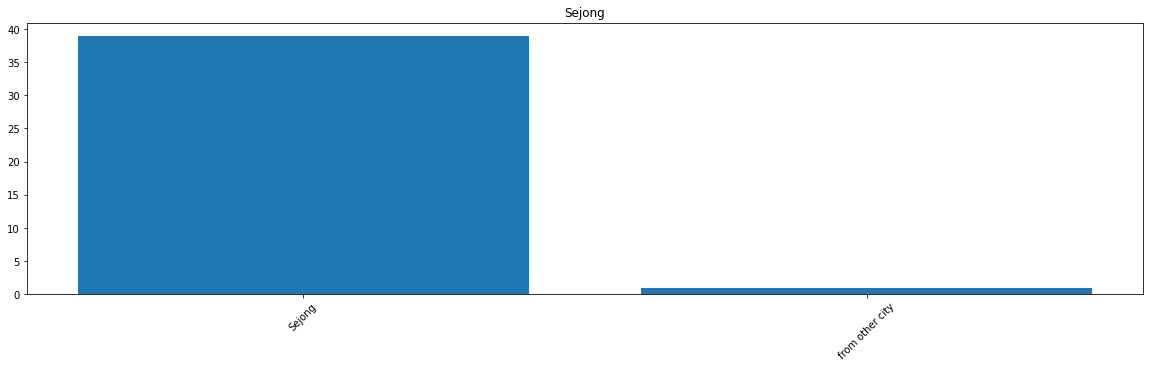

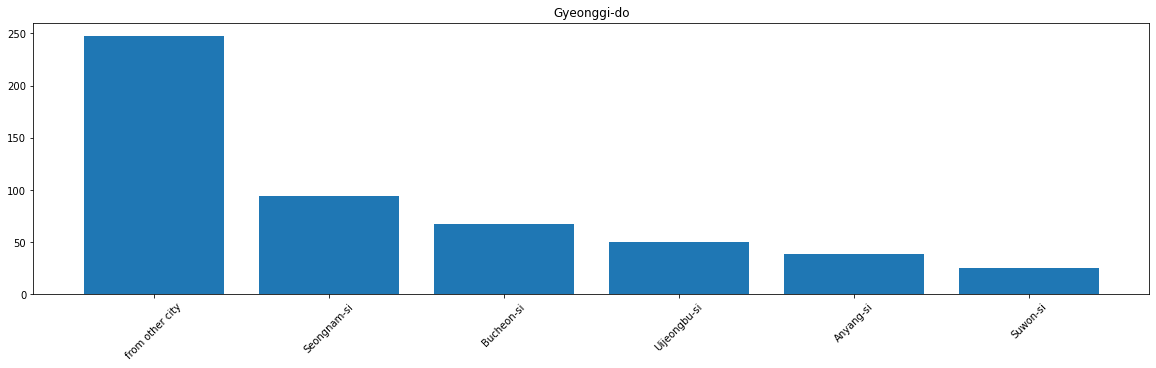

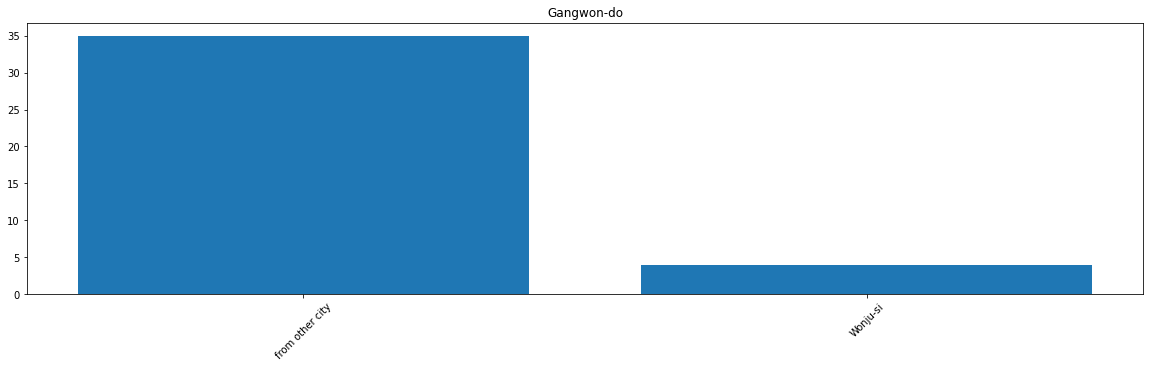

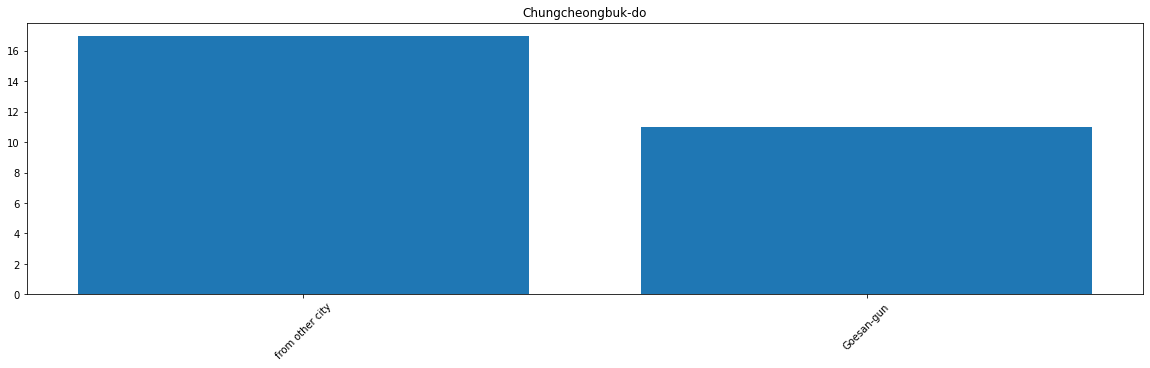

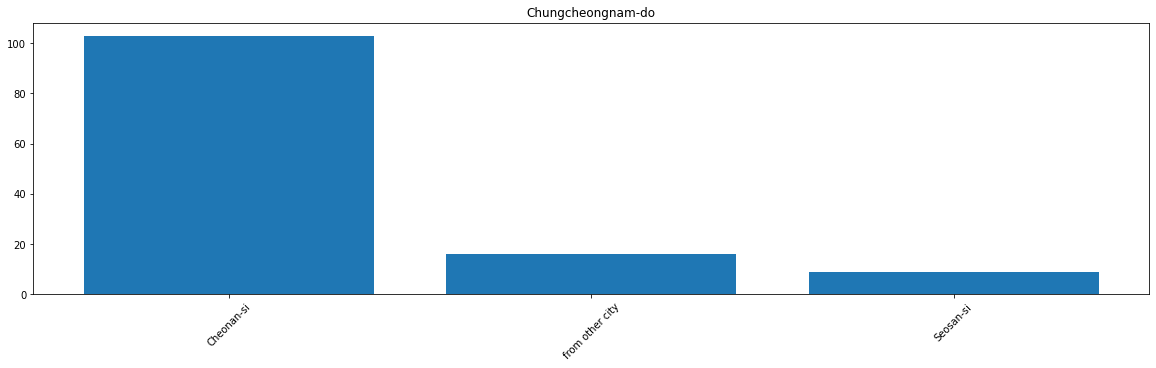

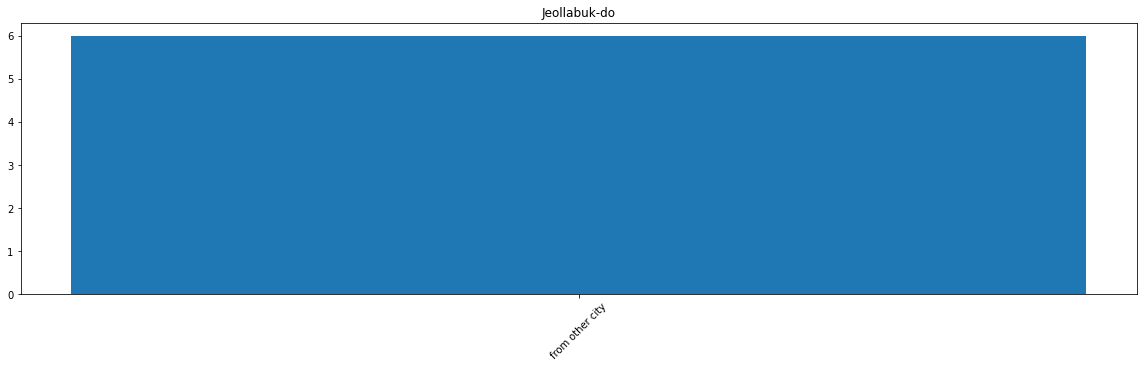

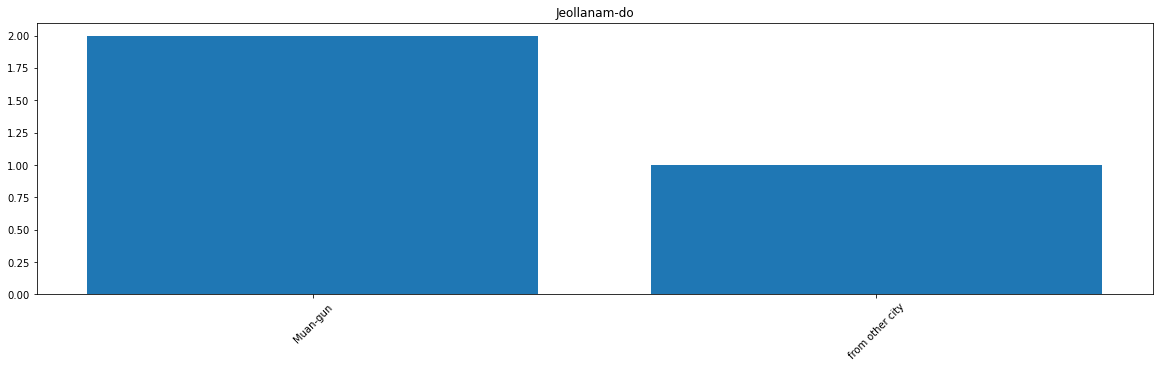

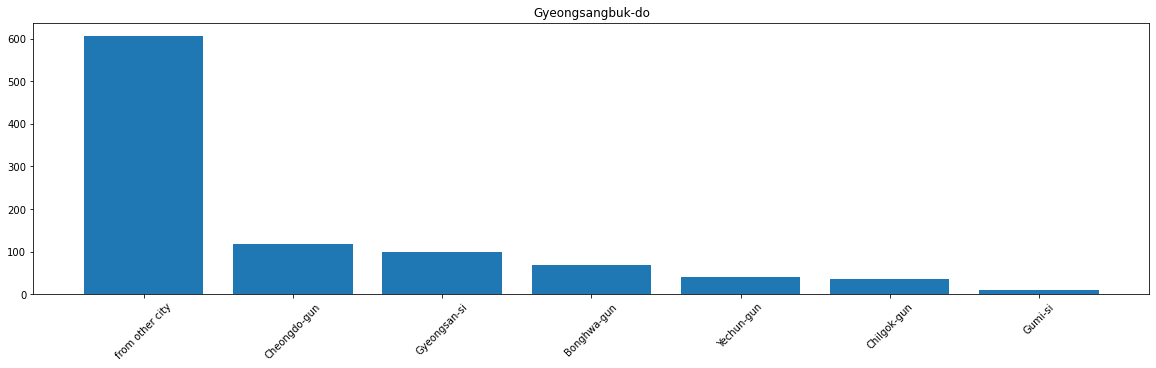

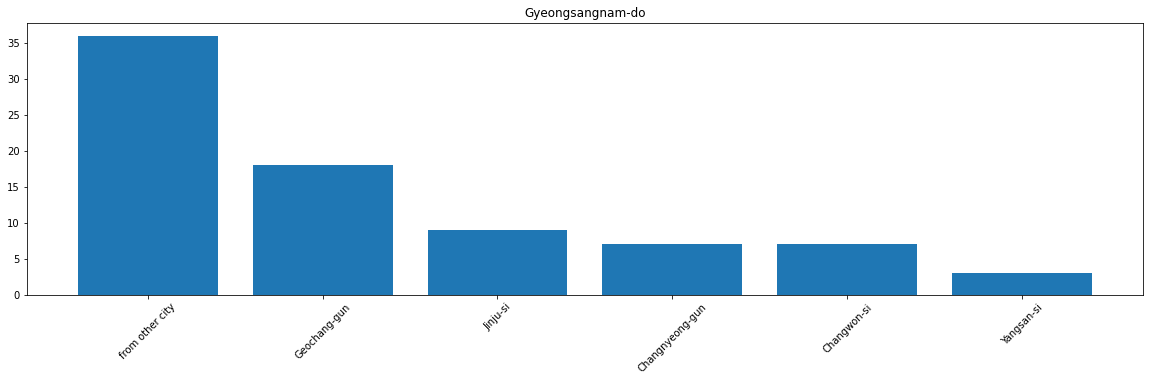

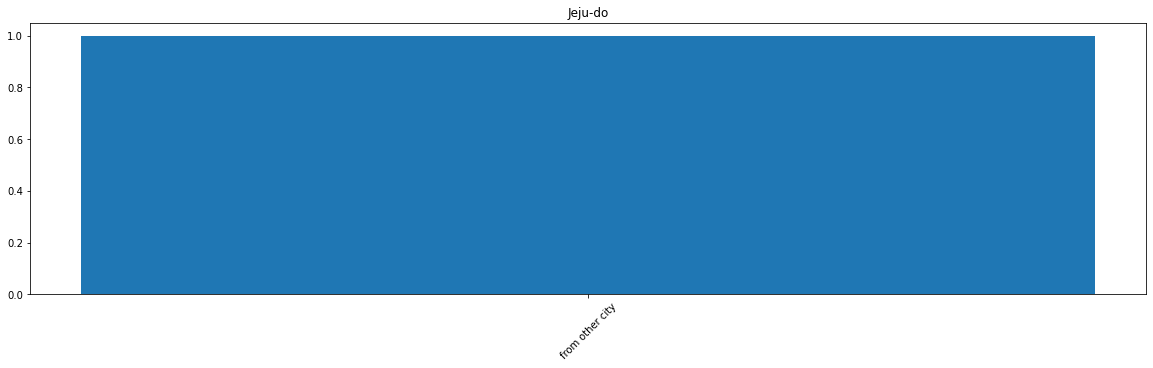

In [50]:
case = pd.read_csv('Case.csv')

df = pd.DataFrame({
    #'case_id': case['case_id'],  ## 왜 이건 안 돼???
    'province': case['province'],
    'city': case['city'],
    'group': case['group'],
    'infection_case': case['infection_case'],
    'confirmed': case['confirmed'],
    'latitude': case['latitude'],
    'longitude': case['longitude']
})

df = df.drop(df.loc[df['city']=='-'].index, inplace=False) # city열에서 '구' 이름 미표기된 곳 제거

province = df['province'].unique()
city = df['city'].unique()

for name in province:
    df_ = df[df['province'] == name].groupby('city').sum().sort_values(by=['confirmed'], axis=0, ascending=False)
        # 위의 지역(province) 리스트에 있는 시별로 구를 그룹화하고 구별로 합산함
    plt.figure(figsize = (20, 5))
    plt.bar(df_.index, df_['confirmed'])
        # df 테이블에서 확진자 수 그래프
    plt.title(name)
    plt.xticks(rotation = 45)
    plt.show()

## 14.회고

박종훈 : 여러 종류의 데이터에서 유의미한 정보를 얻어낸다는 것이 어려운 작업이라는 것을 다시 한번 깨달을 수 있었던 프로젝트였던 것 같다. 주제 선언에 가장 큰 어려움을 겪었고 그것을 어떤 시각화 방식을 통해서 전달해야 데이터를 보는 사람들에게 쉽게 정보전달을 할 수 있는지를 고민해볼 수 있었던 유익한 프로젝트였다.

양윤정 : 코로나 프로젝트로 인해 새로운 코드도 배우고 그동안 공부했던 그래프 그리는 방법들을 연습할 수 있어서 큰 도움이 되었다.

이유정 : Seaborn의 매력에 풍덩 빠졌습니다. 그래도 데이터 분석은 너무 어려워요 ㅜㅜ

조웅제 : 익숙하지 않은 언어로 시각화를 하는것이 항상 어려웠는데 풀잎 진행하면서 연습할 수 있었고 함께 프로젝트까지 진행할  수 있어서 좋았습니다!